In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
# test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [10]:
class_id =train['class_id']

In [11]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [12]:
# year 和 month 进行 one-hot 编码
train.drop_duplicates(inplace=True)
labels = train.sale_quantity[:8120]
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

test = train[8120:].reset_index(drop=True)
train = train[:8120].reset_index(drop=True)

In [13]:
train=pd.concat([train, class_id[:8120]], axis=1)

In [16]:
train

,TR_0,TR_1,TR_4,TR_5,TR_5;4,TR_6,TR_7,TR_8,TR_8;7,TR_9,...,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,class_id
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125403
1,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,136916
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,178529
3,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,194450
4,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,198427
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,209945
6,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,248352
7,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,281301
8,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,290854
9,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,291086


In [34]:
# 获取 2017-10 作为测试集
test_X_id = train[-140:]
test_Y = labels[-140:]

In [35]:
test_class_id=test_X_id['class_id']

In [36]:
test_Y_class_id=pd.DataFrame(test_Y)

In [37]:
test_Y_class_id['class_id']=np.array(test_class_id)

In [38]:
len(test_Y_class_id['class_id'].unique())

140

In [42]:
test_X=test_X_id.drop(['class_id'],axis=1)

In [44]:
# 2013-01 至 2017-10 作为训练集
train_X_id = train[:-140]
train_Y = labels[:-140]

In [47]:
train_class_id=train_X_id['class_id']
train_Y_class_id=pd.DataFrame(train_Y)
train_Y_class_id['class_id']=np.array(train_class_id)

In [49]:
train_X=train_X_id.drop(['class_id'],axis=1)

## 调整 XGBoost 参数

In [50]:
# RMSE = 125
rmses = []
trainset = xgb.DMatrix(train_X,label=train_Y)
testset = xgb.DMatrix(test_X)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((test_Y - predict_test_X) ** 2))

print('This time rmse is: '+ str(rmsetmp))
rmses.append(rmsetmp)

[0]	train-rmse:437.445
[1]	train-rmse:344.719
[2]	train-rmse:280.185
[3]	train-rmse:239.162
[4]	train-rmse:209.888
[5]	train-rmse:189.772
[6]	train-rmse:176.84
[7]	train-rmse:165.504
[8]	train-rmse:157.324
[9]	train-rmse:151.346
[10]	train-rmse:145.07
[11]	train-rmse:141.657
[12]	train-rmse:135.531
[13]	train-rmse:132.187
[14]	train-rmse:129.955
[15]	train-rmse:127.346
[16]	train-rmse:124.413
[17]	train-rmse:121.539
[18]	train-rmse:119.204
[19]	train-rmse:116.399
[20]	train-rmse:113.891
[21]	train-rmse:113.137
[22]	train-rmse:111.031
[23]	train-rmse:109.399
[24]	train-rmse:107.734
[25]	train-rmse:106.429
[26]	train-rmse:105.206
[27]	train-rmse:103.841
[28]	train-rmse:103.158
[29]	train-rmse:102.348
[30]	train-rmse:101.717
[31]	train-rmse:99.5068
[32]	train-rmse:98.89
[33]	train-rmse:97.8808
[34]	train-rmse:97.1908
[35]	train-rmse:96.3225
[36]	train-rmse:95.2712
[37]	train-rmse:94.7767
[38]	train-rmse:93.7811
[39]	train-rmse:92.9941
[40]	train-rmse:91.7425
[41]	train-rmse:91.1143
[42]	t

[334]	train-rmse:19.9138
[335]	train-rmse:19.8226
[336]	train-rmse:19.7608
[337]	train-rmse:19.6728
[338]	train-rmse:19.6049
[339]	train-rmse:19.5017
[340]	train-rmse:19.4269
[341]	train-rmse:19.3647
[342]	train-rmse:19.3518
[343]	train-rmse:19.2753
[344]	train-rmse:19.1816
[345]	train-rmse:19.1068
[346]	train-rmse:19.0225
[347]	train-rmse:18.9783
[348]	train-rmse:18.9552
[349]	train-rmse:18.8758
[350]	train-rmse:18.8185
[351]	train-rmse:18.7521
[352]	train-rmse:18.6741
[353]	train-rmse:18.5893
[354]	train-rmse:18.5072
[355]	train-rmse:18.4455
[356]	train-rmse:18.3747
[357]	train-rmse:18.2862
[358]	train-rmse:18.2348
[359]	train-rmse:18.1818
[360]	train-rmse:18.1053
[361]	train-rmse:18.0534
[362]	train-rmse:17.9669
[363]	train-rmse:17.9171
[364]	train-rmse:17.8315
[365]	train-rmse:17.7518
[366]	train-rmse:17.6966
[367]	train-rmse:17.6234
[368]	train-rmse:17.56
[369]	train-rmse:17.5099
[370]	train-rmse:17.4367
[371]	train-rmse:17.4027
[372]	train-rmse:17.3158
[373]	train-rmse:17.2916
[3

[664]	train-rmse:6.88548
[665]	train-rmse:6.87487
[666]	train-rmse:6.84718
[667]	train-rmse:6.83201
[668]	train-rmse:6.80873
[669]	train-rmse:6.7979
[670]	train-rmse:6.7676
[671]	train-rmse:6.74761
[672]	train-rmse:6.72713
[673]	train-rmse:6.70139
[674]	train-rmse:6.6812
[675]	train-rmse:6.66728
[676]	train-rmse:6.64713
[677]	train-rmse:6.63166
[678]	train-rmse:6.61839
[679]	train-rmse:6.58839
[680]	train-rmse:6.57287
[681]	train-rmse:6.54997
[682]	train-rmse:6.52804
[683]	train-rmse:6.50703
[684]	train-rmse:6.495
[685]	train-rmse:6.47665
[686]	train-rmse:6.46848
[687]	train-rmse:6.45258
[688]	train-rmse:6.43385
[689]	train-rmse:6.4166
[690]	train-rmse:6.40133
[691]	train-rmse:6.38785
[692]	train-rmse:6.36271
[693]	train-rmse:6.34448
[694]	train-rmse:6.33737
[695]	train-rmse:6.3331
[696]	train-rmse:6.31565
[697]	train-rmse:6.26647
[698]	train-rmse:6.24413
[699]	train-rmse:6.2325
[700]	train-rmse:6.20665
[701]	train-rmse:6.19266
[702]	train-rmse:6.17681
[703]	train-rmse:6.17149
[704]	tr

[994]	train-rmse:3.09544
[995]	train-rmse:3.08724
[996]	train-rmse:3.08209
[997]	train-rmse:3.07076
[998]	train-rmse:3.06202
[999]	train-rmse:3.05619
[1000]	train-rmse:3.04812
[1001]	train-rmse:3.04064
[1002]	train-rmse:3.03622
[1003]	train-rmse:3.02873
[1004]	train-rmse:3.01989
[1005]	train-rmse:3.01357
[1006]	train-rmse:3.00377
[1007]	train-rmse:2.99841
[1008]	train-rmse:2.98088
[1009]	train-rmse:2.97467
[1010]	train-rmse:2.97066
[1011]	train-rmse:2.96457
[1012]	train-rmse:2.96102
[1013]	train-rmse:2.95238
[1014]	train-rmse:2.94753
[1015]	train-rmse:2.94127
[1016]	train-rmse:2.93739
[1017]	train-rmse:2.92899
[1018]	train-rmse:2.91983
[1019]	train-rmse:2.91447
[1020]	train-rmse:2.90995
[1021]	train-rmse:2.90621
[1022]	train-rmse:2.90027
[1023]	train-rmse:2.8939
[1024]	train-rmse:2.88775
[1025]	train-rmse:2.88212
[1026]	train-rmse:2.87608
[1027]	train-rmse:2.87281
[1028]	train-rmse:2.86932
[1029]	train-rmse:2.86254
[1030]	train-rmse:2.85835
[1031]	train-rmse:2.85347
[1032]	train-rmse:2

[1311]	train-rmse:1.67838
[1312]	train-rmse:1.67712
[1313]	train-rmse:1.67545
[1314]	train-rmse:1.67306
[1315]	train-rmse:1.67107
[1316]	train-rmse:1.66979
[1317]	train-rmse:1.66783
[1318]	train-rmse:1.66392
[1319]	train-rmse:1.66219
[1320]	train-rmse:1.65914
[1321]	train-rmse:1.65446
[1322]	train-rmse:1.65139
[1323]	train-rmse:1.64936
[1324]	train-rmse:1.64738
[1325]	train-rmse:1.64259
[1326]	train-rmse:1.6409
[1327]	train-rmse:1.63885
[1328]	train-rmse:1.636
[1329]	train-rmse:1.63398
[1330]	train-rmse:1.63119
[1331]	train-rmse:1.62831
[1332]	train-rmse:1.62338
[1333]	train-rmse:1.62071
[1334]	train-rmse:1.61948
[1335]	train-rmse:1.61714
[1336]	train-rmse:1.61613
[1337]	train-rmse:1.61232
[1338]	train-rmse:1.60939
[1339]	train-rmse:1.60779
[1340]	train-rmse:1.60409
[1341]	train-rmse:1.60061
[1342]	train-rmse:1.59756
[1343]	train-rmse:1.59541
[1344]	train-rmse:1.5933
[1345]	train-rmse:1.58629
[1346]	train-rmse:1.58283
[1347]	train-rmse:1.5807
[1348]	train-rmse:1.57876
[1349]	train-rmse

[1628]	train-rmse:1.02935
[1629]	train-rmse:1.02853
[1630]	train-rmse:1.02451
[1631]	train-rmse:1.02365
[1632]	train-rmse:1.02218
[1633]	train-rmse:1.02175
[1634]	train-rmse:1.0202
[1635]	train-rmse:1.01913
[1636]	train-rmse:1.01832
[1637]	train-rmse:1.01742
[1638]	train-rmse:1.01622
[1639]	train-rmse:1.01545
[1640]	train-rmse:1.01348
[1641]	train-rmse:1.01232
[1642]	train-rmse:1.01066
[1643]	train-rmse:1.00976
[1644]	train-rmse:1.00919
[1645]	train-rmse:1.00727
[1646]	train-rmse:1.0057
[1647]	train-rmse:1.00445
[1648]	train-rmse:1.00352
[1649]	train-rmse:1.00227
[1650]	train-rmse:1.00077
[1651]	train-rmse:0.999886
[1652]	train-rmse:0.998556
[1653]	train-rmse:0.997478
[1654]	train-rmse:0.995593
[1655]	train-rmse:0.99481
[1656]	train-rmse:0.992498
[1657]	train-rmse:0.991588
[1658]	train-rmse:0.990553
[1659]	train-rmse:0.989544
[1660]	train-rmse:0.988332
[1661]	train-rmse:0.987705
[1662]	train-rmse:0.984977
[1663]	train-rmse:0.983098
[1664]	train-rmse:0.981795
[1665]	train-rmse:0.980765


[1934]	train-rmse:0.69287
[1935]	train-rmse:0.692488
[1936]	train-rmse:0.691495
[1937]	train-rmse:0.690638
[1938]	train-rmse:0.689116
[1939]	train-rmse:0.68833
[1940]	train-rmse:0.687321
[1941]	train-rmse:0.686632
[1942]	train-rmse:0.685923
[1943]	train-rmse:0.684735
[1944]	train-rmse:0.68381
[1945]	train-rmse:0.68321
[1946]	train-rmse:0.682877
[1947]	train-rmse:0.681771
[1948]	train-rmse:0.681164
[1949]	train-rmse:0.680468
[1950]	train-rmse:0.67885
[1951]	train-rmse:0.678375
[1952]	train-rmse:0.677345
[1953]	train-rmse:0.676958
[1954]	train-rmse:0.676192
[1955]	train-rmse:0.675632
[1956]	train-rmse:0.675259
[1957]	train-rmse:0.673774
[1958]	train-rmse:0.673253
[1959]	train-rmse:0.672754
[1960]	train-rmse:0.67223
[1961]	train-rmse:0.671396
[1962]	train-rmse:0.670777
[1963]	train-rmse:0.670013
[1964]	train-rmse:0.669424
[1965]	train-rmse:0.668905
[1966]	train-rmse:0.668213
[1967]	train-rmse:0.667546
[1968]	train-rmse:0.667031
[1969]	train-rmse:0.666655
[1970]	train-rmse:0.666223
[1971]	

[2239]	train-rmse:0.503547
[2240]	train-rmse:0.503193
[2241]	train-rmse:0.502694
[2242]	train-rmse:0.501981
[2243]	train-rmse:0.501764
[2244]	train-rmse:0.501384
[2245]	train-rmse:0.50074
[2246]	train-rmse:0.500254
[2247]	train-rmse:0.499695
[2248]	train-rmse:0.499289
[2249]	train-rmse:0.498716
[2250]	train-rmse:0.498185
[2251]	train-rmse:0.497535
[2252]	train-rmse:0.49711
[2253]	train-rmse:0.496406
[2254]	train-rmse:0.495969
[2255]	train-rmse:0.495785
[2256]	train-rmse:0.495268
[2257]	train-rmse:0.493895
[2258]	train-rmse:0.49352
[2259]	train-rmse:0.493353
[2260]	train-rmse:0.492856
[2261]	train-rmse:0.492253
[2262]	train-rmse:0.491705
[2263]	train-rmse:0.490773
[2264]	train-rmse:0.490546
[2265]	train-rmse:0.490254
[2266]	train-rmse:0.489996
[2267]	train-rmse:0.489478
[2268]	train-rmse:0.489159
[2269]	train-rmse:0.488306
[2270]	train-rmse:0.487718
[2271]	train-rmse:0.487355
[2272]	train-rmse:0.48691
[2273]	train-rmse:0.486696
[2274]	train-rmse:0.485211
[2275]	train-rmse:0.48475
[2276]

[2544]	train-rmse:0.376821
[2545]	train-rmse:0.376428
[2546]	train-rmse:0.376188
[2547]	train-rmse:0.376007
[2548]	train-rmse:0.375256
[2549]	train-rmse:0.375045
[2550]	train-rmse:0.374737
[2551]	train-rmse:0.37433
[2552]	train-rmse:0.374212
[2553]	train-rmse:0.373932
[2554]	train-rmse:0.3736
[2555]	train-rmse:0.373356
[2556]	train-rmse:0.373122
[2557]	train-rmse:0.372882
[2558]	train-rmse:0.372742
[2559]	train-rmse:0.372172
[2560]	train-rmse:0.372029
[2561]	train-rmse:0.37142
[2562]	train-rmse:0.371192
[2563]	train-rmse:0.371007
[2564]	train-rmse:0.370743
[2565]	train-rmse:0.370505
[2566]	train-rmse:0.370259
[2567]	train-rmse:0.369705
[2568]	train-rmse:0.369019
[2569]	train-rmse:0.368826
[2570]	train-rmse:0.368481
[2571]	train-rmse:0.368277
[2572]	train-rmse:0.367929
[2573]	train-rmse:0.36757
[2574]	train-rmse:0.367436
[2575]	train-rmse:0.36733
[2576]	train-rmse:0.36709
[2577]	train-rmse:0.366871
[2578]	train-rmse:0.366686
[2579]	train-rmse:0.366462
[2580]	train-rmse:0.366198
[2581]	t

[2849]	train-rmse:0.295457
[2850]	train-rmse:0.295111
[2851]	train-rmse:0.295008
[2852]	train-rmse:0.294766
[2853]	train-rmse:0.294594
[2854]	train-rmse:0.294472
[2855]	train-rmse:0.294291
[2856]	train-rmse:0.2941
[2857]	train-rmse:0.293709
[2858]	train-rmse:0.29353
[2859]	train-rmse:0.293484
[2860]	train-rmse:0.293141
[2861]	train-rmse:0.292835
[2862]	train-rmse:0.292654
[2863]	train-rmse:0.292408
[2864]	train-rmse:0.292184
[2865]	train-rmse:0.292102
[2866]	train-rmse:0.291932
[2867]	train-rmse:0.291544
[2868]	train-rmse:0.291286
[2869]	train-rmse:0.29114
[2870]	train-rmse:0.291079
[2871]	train-rmse:0.290875
[2872]	train-rmse:0.290707
[2873]	train-rmse:0.290537
[2874]	train-rmse:0.290244
[2875]	train-rmse:0.289982
[2876]	train-rmse:0.289635
[2877]	train-rmse:0.289476
[2878]	train-rmse:0.289466
[2879]	train-rmse:0.289301
[2880]	train-rmse:0.2891
[2881]	train-rmse:0.288888
[2882]	train-rmse:0.288525
[2883]	train-rmse:0.288361
[2884]	train-rmse:0.288274
[2885]	train-rmse:0.288081
[2886]	

[3154]	train-rmse:0.244768
[3155]	train-rmse:0.244719
[3156]	train-rmse:0.244537
[3157]	train-rmse:0.244281
[3158]	train-rmse:0.244269
[3159]	train-rmse:0.244169
[3160]	train-rmse:0.244036
[3161]	train-rmse:0.243915
[3162]	train-rmse:0.24373
[3163]	train-rmse:0.243624
[3164]	train-rmse:0.243546
[3165]	train-rmse:0.243484
[3166]	train-rmse:0.243405
[3167]	train-rmse:0.24323
[3168]	train-rmse:0.243183
[3169]	train-rmse:0.243035
[3170]	train-rmse:0.242978
[3171]	train-rmse:0.242797
[3172]	train-rmse:0.24257
[3173]	train-rmse:0.242473
[3174]	train-rmse:0.242364
[3175]	train-rmse:0.242228
[3176]	train-rmse:0.242148
[3177]	train-rmse:0.241933
[3178]	train-rmse:0.24182
[3179]	train-rmse:0.241764
[3180]	train-rmse:0.241694
[3181]	train-rmse:0.241632
[3182]	train-rmse:0.241499
[3183]	train-rmse:0.24136
[3184]	train-rmse:0.241236
[3185]	train-rmse:0.241147
[3186]	train-rmse:0.241021
[3187]	train-rmse:0.240891
[3188]	train-rmse:0.24084
[3189]	train-rmse:0.240668
[3190]	train-rmse:0.24056
[3191]	t

[3459]	train-rmse:0.212924
[3460]	train-rmse:0.212815
[3461]	train-rmse:0.212694
[3462]	train-rmse:0.212478
[3463]	train-rmse:0.212477
[3464]	train-rmse:0.212372
[3465]	train-rmse:0.212317
[3466]	train-rmse:0.212112
[3467]	train-rmse:0.211967
[3468]	train-rmse:0.211864
[3469]	train-rmse:0.211776
[3470]	train-rmse:0.211573
[3471]	train-rmse:0.211527
[3472]	train-rmse:0.211432
[3473]	train-rmse:0.211377
[3474]	train-rmse:0.211262
[3475]	train-rmse:0.211227
[3476]	train-rmse:0.211161
[3477]	train-rmse:0.211086
[3478]	train-rmse:0.211056
[3479]	train-rmse:0.210938
[3480]	train-rmse:0.21087
[3481]	train-rmse:0.210791
[3482]	train-rmse:0.210749
[3483]	train-rmse:0.210694
[3484]	train-rmse:0.210681
[3485]	train-rmse:0.210653
[3486]	train-rmse:0.210448
[3487]	train-rmse:0.210418
[3488]	train-rmse:0.210331
[3489]	train-rmse:0.210251
[3490]	train-rmse:0.210169
[3491]	train-rmse:0.210117
[3492]	train-rmse:0.21009
[3493]	train-rmse:0.210066
[3494]	train-rmse:0.210029
[3495]	train-rmse:0.209944
[34

[3764]	train-rmse:0.194554
[3765]	train-rmse:0.194481
[3766]	train-rmse:0.19447
[3767]	train-rmse:0.194262
[3768]	train-rmse:0.194183
[3769]	train-rmse:0.194154
[3770]	train-rmse:0.194114
[3771]	train-rmse:0.194057
[3772]	train-rmse:0.194014
[3773]	train-rmse:0.193872
[3774]	train-rmse:0.193831
[3775]	train-rmse:0.193804
[3776]	train-rmse:0.193804
[3777]	train-rmse:0.193804
[3778]	train-rmse:0.193659
[3779]	train-rmse:0.193632
[3780]	train-rmse:0.19361
[3781]	train-rmse:0.193601
[3782]	train-rmse:0.193568
[3783]	train-rmse:0.193529
[3784]	train-rmse:0.193486
[3785]	train-rmse:0.193464
[3786]	train-rmse:0.193426
[3787]	train-rmse:0.193426
[3788]	train-rmse:0.193371
[3789]	train-rmse:0.193282
[3790]	train-rmse:0.193233
[3791]	train-rmse:0.193181
[3792]	train-rmse:0.193145
[3793]	train-rmse:0.193056
[3794]	train-rmse:0.192993
[3795]	train-rmse:0.192923
[3796]	train-rmse:0.192892
[3797]	train-rmse:0.19282
[3798]	train-rmse:0.192792
[3799]	train-rmse:0.19278
[3800]	train-rmse:0.192751
[3801

In [53]:
sabs=abs(test_Y-predict_test_X)
err_r=sabs/test_Y
err_r=pd.DataFrame({'err_r':err_r})
err_Y = pd.concat([err_r,test_Y_class_id],axis=1)
#err_Y['multi']=err_Y['err_r']*err_Y['sale_quantity_10']

In [55]:
err_Y['err_num']=err_Y['err_r']*err_Y['sale_quantity']

In [61]:
err_Y[err_Y['err_num']>=100].count()

err_r            44
sale_quantity    44
class_id         44
err_num          44
dtype: int64

In [62]:
rmsetmp = sp.sqrt(sp.mean((err_Y[err_Y['err_num']>100]['err_num']-0) ** 2))
rmsetmp

235.74557116721869

# 将差值大于100的id挑出来，包括train和test的数据，重新跑一次xgboost

In [64]:
test_Y_err_100=err_Y[err_Y['err_num']>=100]

In [66]:
test_Y_100=test_Y_err_100['sale_quantity']

In [69]:
test_Y_100_id=test_Y_err_100['class_id']

In [80]:
test_Y_err_99=err_Y[err_Y['err_num']<100]
test_Y_99_id=test_Y_err_99['class_id']

In [82]:
len(test_Y_99_id)

96

In [89]:
#从test数据中去掉绝对差值小于100的值的id的行数，这样保证不破坏test_X_id_100的class_id的顺序，从而保证预测值和test_Y_100值可以一一对应
test_X_id_100=test_X_id
for i in test_Y_99_id:
    test_X_id_100=test_X_id_100[test_X_id_100.class_id!=i]

In [93]:
train_X_id_100=train_X_id
for i in test_Y_99_id:
    train_X_id_100=train_X_id_100[train_X_id_100.class_id!=i]


In [94]:
train_Y_class_id_100=train_Y_class_id
for i in test_Y_99_id:
    train_Y_class_id_100=train_Y_class_id_100[train_Y_class_id_100.class_id!=i]

In [97]:
train_X_100=train_X_id_100.drop(['class_id'],axis=1)

In [98]:
train_Y_100=train_Y_class_id_100.drop(['class_id'],axis=1)

In [100]:
test_X_100=test_X_id_100.drop(['class_id'],axis=1)

In [117]:
%%time

rmses_100 = []
trainset_100 = xgb.DMatrix(train_X_100,label=train_Y_100)
testset_100 = xgb.DMatrix(test_X_100)

params_100 = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear' , # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 2, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 20, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist_100 = [(trainset_100,'train')]
model_100 = xgb.train(params_100, trainset_100, num_boost_round=4000,evals=watchlist_100)
predict_test_X_100 = model_100.predict(testset_100)
rmsetmp_100 = sp.sqrt(sp.mean((test_Y_100 - predict_test_X_100) ** 2))

print('This time rmse is: '+ str(rmsetmp_100))
rmses_100.append(rmsetmp_100)

[0]	train-rmse:706.731
[1]	train-rmse:566.221
[2]	train-rmse:467.781
[3]	train-rmse:400.05
[4]	train-rmse:349.232
[5]	train-rmse:316.614
[6]	train-rmse:294.879
[7]	train-rmse:275.991
[8]	train-rmse:263.241
[9]	train-rmse:252.432
[10]	train-rmse:241.761
[11]	train-rmse:232.528
[12]	train-rmse:224.655
[13]	train-rmse:217.676
[14]	train-rmse:210.619
[15]	train-rmse:204.501
[16]	train-rmse:200.496
[17]	train-rmse:194.987
[18]	train-rmse:190.322
[19]	train-rmse:185.489
[20]	train-rmse:181.51
[21]	train-rmse:177.124
[22]	train-rmse:173.444
[23]	train-rmse:170.526
[24]	train-rmse:166.157
[25]	train-rmse:164.354
[26]	train-rmse:161.052
[27]	train-rmse:158.718
[28]	train-rmse:156.098
[29]	train-rmse:153.731
[30]	train-rmse:151.942
[31]	train-rmse:149.814
[32]	train-rmse:147.846
[33]	train-rmse:145.577
[34]	train-rmse:144.371
[35]	train-rmse:141.948
[36]	train-rmse:139.876
[37]	train-rmse:137.693
[38]	train-rmse:135.937
[39]	train-rmse:134.294
[40]	train-rmse:132.79
[41]	train-rmse:130.854
[42]	

[334]	train-rmse:15.1663
[335]	train-rmse:15.0612
[336]	train-rmse:14.9583
[337]	train-rmse:14.8365
[338]	train-rmse:14.747
[339]	train-rmse:14.6794
[340]	train-rmse:14.5792
[341]	train-rmse:14.4879
[342]	train-rmse:14.4013
[343]	train-rmse:14.317
[344]	train-rmse:14.224
[345]	train-rmse:14.1533
[346]	train-rmse:14.0957
[347]	train-rmse:14.0083
[348]	train-rmse:13.9516
[349]	train-rmse:13.8931
[350]	train-rmse:13.8349
[351]	train-rmse:13.7484
[352]	train-rmse:13.6648
[353]	train-rmse:13.6293
[354]	train-rmse:13.5674
[355]	train-rmse:13.4678
[356]	train-rmse:13.3972
[357]	train-rmse:13.3307
[358]	train-rmse:13.2476
[359]	train-rmse:13.1656
[360]	train-rmse:13.1275
[361]	train-rmse:13.0677
[362]	train-rmse:12.9772
[363]	train-rmse:12.8965
[364]	train-rmse:12.8188
[365]	train-rmse:12.762
[366]	train-rmse:12.6969
[367]	train-rmse:12.6552
[368]	train-rmse:12.568
[369]	train-rmse:12.498
[370]	train-rmse:12.4259
[371]	train-rmse:12.3642
[372]	train-rmse:12.309
[373]	train-rmse:12.2396
[374]	t

[664]	train-rmse:3.10918
[665]	train-rmse:3.09568
[666]	train-rmse:3.08721
[667]	train-rmse:3.08179
[668]	train-rmse:3.07025
[669]	train-rmse:3.06488
[670]	train-rmse:3.05772
[671]	train-rmse:3.05087
[672]	train-rmse:3.03712
[673]	train-rmse:3.02825
[674]	train-rmse:3.017
[675]	train-rmse:3.00483
[676]	train-rmse:2.99429
[677]	train-rmse:2.98667
[678]	train-rmse:2.97007
[679]	train-rmse:2.95266
[680]	train-rmse:2.9437
[681]	train-rmse:2.92926
[682]	train-rmse:2.91945
[683]	train-rmse:2.90905
[684]	train-rmse:2.90294
[685]	train-rmse:2.8849
[686]	train-rmse:2.87496
[687]	train-rmse:2.85076
[688]	train-rmse:2.83922
[689]	train-rmse:2.82633
[690]	train-rmse:2.80198
[691]	train-rmse:2.78821
[692]	train-rmse:2.76881
[693]	train-rmse:2.75951
[694]	train-rmse:2.75058
[695]	train-rmse:2.74128
[696]	train-rmse:2.73405
[697]	train-rmse:2.71957
[698]	train-rmse:2.7123
[699]	train-rmse:2.70526
[700]	train-rmse:2.69768
[701]	train-rmse:2.69051
[702]	train-rmse:2.67885
[703]	train-rmse:2.67057
[704]

[994]	train-rmse:1.00203
[995]	train-rmse:0.998465
[996]	train-rmse:0.996483
[997]	train-rmse:0.993376
[998]	train-rmse:0.989378
[999]	train-rmse:0.986422
[1000]	train-rmse:0.984104
[1001]	train-rmse:0.980928
[1002]	train-rmse:0.97707
[1003]	train-rmse:0.975442
[1004]	train-rmse:0.972636
[1005]	train-rmse:0.970951
[1006]	train-rmse:0.96878
[1007]	train-rmse:0.96782
[1008]	train-rmse:0.964861
[1009]	train-rmse:0.960103
[1010]	train-rmse:0.957412
[1011]	train-rmse:0.953767
[1012]	train-rmse:0.950839
[1013]	train-rmse:0.94867
[1014]	train-rmse:0.946412
[1015]	train-rmse:0.944074
[1016]	train-rmse:0.942168
[1017]	train-rmse:0.939014
[1018]	train-rmse:0.937635
[1019]	train-rmse:0.935174
[1020]	train-rmse:0.932876
[1021]	train-rmse:0.929514
[1022]	train-rmse:0.927083
[1023]	train-rmse:0.924894
[1024]	train-rmse:0.922248
[1025]	train-rmse:0.920021
[1026]	train-rmse:0.918088
[1027]	train-rmse:0.91549
[1028]	train-rmse:0.91285
[1029]	train-rmse:0.910501
[1030]	train-rmse:0.908472
[1031]	train-r

[1300]	train-rmse:0.468368
[1301]	train-rmse:0.467237
[1302]	train-rmse:0.465037
[1303]	train-rmse:0.464148
[1304]	train-rmse:0.463463
[1305]	train-rmse:0.462277
[1306]	train-rmse:0.46197
[1307]	train-rmse:0.460901
[1308]	train-rmse:0.459883
[1309]	train-rmse:0.45831
[1310]	train-rmse:0.457609
[1311]	train-rmse:0.456283
[1312]	train-rmse:0.45491
[1313]	train-rmse:0.45389
[1314]	train-rmse:0.452964
[1315]	train-rmse:0.45225
[1316]	train-rmse:0.451339
[1317]	train-rmse:0.450867
[1318]	train-rmse:0.449721
[1319]	train-rmse:0.448541
[1320]	train-rmse:0.447765
[1321]	train-rmse:0.447099
[1322]	train-rmse:0.445776
[1323]	train-rmse:0.444641
[1324]	train-rmse:0.443801
[1325]	train-rmse:0.442141
[1326]	train-rmse:0.441177
[1327]	train-rmse:0.440216
[1328]	train-rmse:0.439507
[1329]	train-rmse:0.438671
[1330]	train-rmse:0.438024
[1331]	train-rmse:0.436926
[1332]	train-rmse:0.436263
[1333]	train-rmse:0.43552
[1334]	train-rmse:0.434997
[1335]	train-rmse:0.433856
[1336]	train-rmse:0.432666
[1337]	

[1605]	train-rmse:0.274924
[1606]	train-rmse:0.274503
[1607]	train-rmse:0.274315
[1608]	train-rmse:0.273782
[1609]	train-rmse:0.273488
[1610]	train-rmse:0.273206
[1611]	train-rmse:0.273074
[1612]	train-rmse:0.272966
[1613]	train-rmse:0.272487
[1614]	train-rmse:0.272024
[1615]	train-rmse:0.271423
[1616]	train-rmse:0.270928
[1617]	train-rmse:0.270789
[1618]	train-rmse:0.270548
[1619]	train-rmse:0.269956
[1620]	train-rmse:0.269812
[1621]	train-rmse:0.269459
[1622]	train-rmse:0.268959
[1623]	train-rmse:0.268566
[1624]	train-rmse:0.268475
[1625]	train-rmse:0.267774
[1626]	train-rmse:0.267653
[1627]	train-rmse:0.267297
[1628]	train-rmse:0.266777
[1629]	train-rmse:0.266644
[1630]	train-rmse:0.266071
[1631]	train-rmse:0.265709
[1632]	train-rmse:0.265098
[1633]	train-rmse:0.26475
[1634]	train-rmse:0.264407
[1635]	train-rmse:0.264276
[1636]	train-rmse:0.264142
[1637]	train-rmse:0.263991
[1638]	train-rmse:0.263507
[1639]	train-rmse:0.263037
[1640]	train-rmse:0.262991
[1641]	train-rmse:0.26287
[16

[1910]	train-rmse:0.214424
[1911]	train-rmse:0.214316
[1912]	train-rmse:0.214279
[1913]	train-rmse:0.214059
[1914]	train-rmse:0.213804
[1915]	train-rmse:0.213803
[1916]	train-rmse:0.213687
[1917]	train-rmse:0.213462
[1918]	train-rmse:0.213418
[1919]	train-rmse:0.213377
[1920]	train-rmse:0.21324
[1921]	train-rmse:0.213217
[1922]	train-rmse:0.213096
[1923]	train-rmse:0.212992
[1924]	train-rmse:0.212938
[1925]	train-rmse:0.212805
[1926]	train-rmse:0.212725
[1927]	train-rmse:0.212567
[1928]	train-rmse:0.212466
[1929]	train-rmse:0.212465
[1930]	train-rmse:0.212288
[1931]	train-rmse:0.212211
[1932]	train-rmse:0.212162
[1933]	train-rmse:0.212045
[1934]	train-rmse:0.212044
[1935]	train-rmse:0.212027
[1936]	train-rmse:0.21198
[1937]	train-rmse:0.211822
[1938]	train-rmse:0.211814
[1939]	train-rmse:0.211677
[1940]	train-rmse:0.211614
[1941]	train-rmse:0.211297
[1942]	train-rmse:0.211275
[1943]	train-rmse:0.211208
[1944]	train-rmse:0.211129
[1945]	train-rmse:0.211024
[1946]	train-rmse:0.210968
[19

[2215]	train-rmse:0.192882
[2216]	train-rmse:0.192839
[2217]	train-rmse:0.192839
[2218]	train-rmse:0.192838
[2219]	train-rmse:0.192658
[2220]	train-rmse:0.192659
[2221]	train-rmse:0.192535
[2222]	train-rmse:0.192535
[2223]	train-rmse:0.192531
[2224]	train-rmse:0.192451
[2225]	train-rmse:0.192397
[2226]	train-rmse:0.192338
[2227]	train-rmse:0.1923
[2228]	train-rmse:0.192227
[2229]	train-rmse:0.192101
[2230]	train-rmse:0.192083
[2231]	train-rmse:0.192085
[2232]	train-rmse:0.192059
[2233]	train-rmse:0.191945
[2234]	train-rmse:0.191938
[2235]	train-rmse:0.191735
[2236]	train-rmse:0.191689
[2237]	train-rmse:0.19169
[2238]	train-rmse:0.191692
[2239]	train-rmse:0.191692
[2240]	train-rmse:0.19166
[2241]	train-rmse:0.191657
[2242]	train-rmse:0.191435
[2243]	train-rmse:0.191314
[2244]	train-rmse:0.191223
[2245]	train-rmse:0.191222
[2246]	train-rmse:0.191223
[2247]	train-rmse:0.191131
[2248]	train-rmse:0.191131
[2249]	train-rmse:0.191118
[2250]	train-rmse:0.19106
[2251]	train-rmse:0.191007
[2252]

[2520]	train-rmse:0.181299
[2521]	train-rmse:0.181256
[2522]	train-rmse:0.181255
[2523]	train-rmse:0.181147
[2524]	train-rmse:0.181116
[2525]	train-rmse:0.181115
[2526]	train-rmse:0.181115
[2527]	train-rmse:0.181059
[2528]	train-rmse:0.181059
[2529]	train-rmse:0.181047
[2530]	train-rmse:0.181047
[2531]	train-rmse:0.181048
[2532]	train-rmse:0.180986
[2533]	train-rmse:0.180928
[2534]	train-rmse:0.180927
[2535]	train-rmse:0.180904
[2536]	train-rmse:0.180812
[2537]	train-rmse:0.180816
[2538]	train-rmse:0.18082
[2539]	train-rmse:0.18077
[2540]	train-rmse:0.180752
[2541]	train-rmse:0.180752
[2542]	train-rmse:0.180753
[2543]	train-rmse:0.180753
[2544]	train-rmse:0.180753
[2545]	train-rmse:0.180755
[2546]	train-rmse:0.180753
[2547]	train-rmse:0.180753
[2548]	train-rmse:0.180752
[2549]	train-rmse:0.180751
[2550]	train-rmse:0.180575
[2551]	train-rmse:0.180575
[2552]	train-rmse:0.180602
[2553]	train-rmse:0.180605
[2554]	train-rmse:0.180593
[2555]	train-rmse:0.180593
[2556]	train-rmse:0.180577
[25

[2825]	train-rmse:0.175076
[2826]	train-rmse:0.17505
[2827]	train-rmse:0.175051
[2828]	train-rmse:0.174977
[2829]	train-rmse:0.17498
[2830]	train-rmse:0.174933
[2831]	train-rmse:0.174941
[2832]	train-rmse:0.174942
[2833]	train-rmse:0.174942
[2834]	train-rmse:0.174954
[2835]	train-rmse:0.174949
[2836]	train-rmse:0.174949
[2837]	train-rmse:0.17495
[2838]	train-rmse:0.174898
[2839]	train-rmse:0.174896
[2840]	train-rmse:0.174896
[2841]	train-rmse:0.174897
[2842]	train-rmse:0.174897
[2843]	train-rmse:0.174899
[2844]	train-rmse:0.174897
[2845]	train-rmse:0.174897
[2846]	train-rmse:0.174897
[2847]	train-rmse:0.174834
[2848]	train-rmse:0.174837
[2849]	train-rmse:0.174812
[2850]	train-rmse:0.174781
[2851]	train-rmse:0.174785
[2852]	train-rmse:0.174782
[2853]	train-rmse:0.174781
[2854]	train-rmse:0.174779
[2855]	train-rmse:0.174776
[2856]	train-rmse:0.174776
[2857]	train-rmse:0.174759
[2858]	train-rmse:0.174758
[2859]	train-rmse:0.174758
[2860]	train-rmse:0.174699
[2861]	train-rmse:0.174574
[286

[3130]	train-rmse:0.17146
[3131]	train-rmse:0.171458
[3132]	train-rmse:0.171429
[3133]	train-rmse:0.171413
[3134]	train-rmse:0.171424
[3135]	train-rmse:0.171424
[3136]	train-rmse:0.171423
[3137]	train-rmse:0.171426
[3138]	train-rmse:0.171424
[3139]	train-rmse:0.171392
[3140]	train-rmse:0.171392
[3141]	train-rmse:0.171392
[3142]	train-rmse:0.171393
[3143]	train-rmse:0.171392
[3144]	train-rmse:0.171394
[3145]	train-rmse:0.171393
[3146]	train-rmse:0.171392
[3147]	train-rmse:0.171397
[3148]	train-rmse:0.171397
[3149]	train-rmse:0.171397
[3150]	train-rmse:0.171397
[3151]	train-rmse:0.171399
[3152]	train-rmse:0.171397
[3153]	train-rmse:0.171403
[3154]	train-rmse:0.171402
[3155]	train-rmse:0.171402
[3156]	train-rmse:0.171403
[3157]	train-rmse:0.171402
[3158]	train-rmse:0.171403
[3159]	train-rmse:0.171402
[3160]	train-rmse:0.171406
[3161]	train-rmse:0.171402
[3162]	train-rmse:0.171353
[3163]	train-rmse:0.171353
[3164]	train-rmse:0.171343
[3165]	train-rmse:0.171315
[3166]	train-rmse:0.171312
[3

[3435]	train-rmse:0.168709
[3436]	train-rmse:0.168709
[3437]	train-rmse:0.168709
[3438]	train-rmse:0.168709
[3439]	train-rmse:0.16871
[3440]	train-rmse:0.168614
[3441]	train-rmse:0.168558
[3442]	train-rmse:0.168557
[3443]	train-rmse:0.168555
[3444]	train-rmse:0.168555
[3445]	train-rmse:0.168553
[3446]	train-rmse:0.168554
[3447]	train-rmse:0.16855
[3448]	train-rmse:0.168548
[3449]	train-rmse:0.168536
[3450]	train-rmse:0.168538
[3451]	train-rmse:0.168539
[3452]	train-rmse:0.168442
[3453]	train-rmse:0.168442
[3454]	train-rmse:0.168443
[3455]	train-rmse:0.168444
[3456]	train-rmse:0.168372
[3457]	train-rmse:0.168369
[3458]	train-rmse:0.168371
[3459]	train-rmse:0.168369
[3460]	train-rmse:0.168369
[3461]	train-rmse:0.168369
[3462]	train-rmse:0.168283
[3463]	train-rmse:0.168284
[3464]	train-rmse:0.168286
[3465]	train-rmse:0.168251
[3466]	train-rmse:0.168249
[3467]	train-rmse:0.16825
[3468]	train-rmse:0.168249
[3469]	train-rmse:0.168256
[3470]	train-rmse:0.168258
[3471]	train-rmse:0.168254
[347

[3741]	train-rmse:0.166092
[3742]	train-rmse:0.166091
[3743]	train-rmse:0.166083
[3744]	train-rmse:0.166083
[3745]	train-rmse:0.166083
[3746]	train-rmse:0.166083
[3747]	train-rmse:0.166081
[3748]	train-rmse:0.166083
[3749]	train-rmse:0.166083
[3750]	train-rmse:0.166085
[3751]	train-rmse:0.166086
[3752]	train-rmse:0.166084
[3753]	train-rmse:0.166083
[3754]	train-rmse:0.166083
[3755]	train-rmse:0.166084
[3756]	train-rmse:0.166086
[3757]	train-rmse:0.166088
[3758]	train-rmse:0.166085
[3759]	train-rmse:0.166087
[3760]	train-rmse:0.166067
[3761]	train-rmse:0.166067
[3762]	train-rmse:0.166065
[3763]	train-rmse:0.166067
[3764]	train-rmse:0.166066
[3765]	train-rmse:0.166076
[3766]	train-rmse:0.166067
[3767]	train-rmse:0.16607
[3768]	train-rmse:0.166042
[3769]	train-rmse:0.166013
[3770]	train-rmse:0.166014
[3771]	train-rmse:0.166015
[3772]	train-rmse:0.166015
[3773]	train-rmse:0.16605
[3774]	train-rmse:0.166049
[3775]	train-rmse:0.166051
[3776]	train-rmse:0.166033
[3777]	train-rmse:0.166032
[37

'reg:line'  252.145555726 'max_depth': lamma=10

'reg:line'  213.367715437 'max_depth': lamma=20

'reg:tweedie' 254.811186842
'reg:gamma':nan
'count:poisson'229.173655278 'max_depth': 5

### 发现同等参数情况下，用xgboost训练4000步和直接用xgboost的sklearn接口XGBRegressor进行fit的效果：fit的效果会更好.4000步之后没有再看效果。

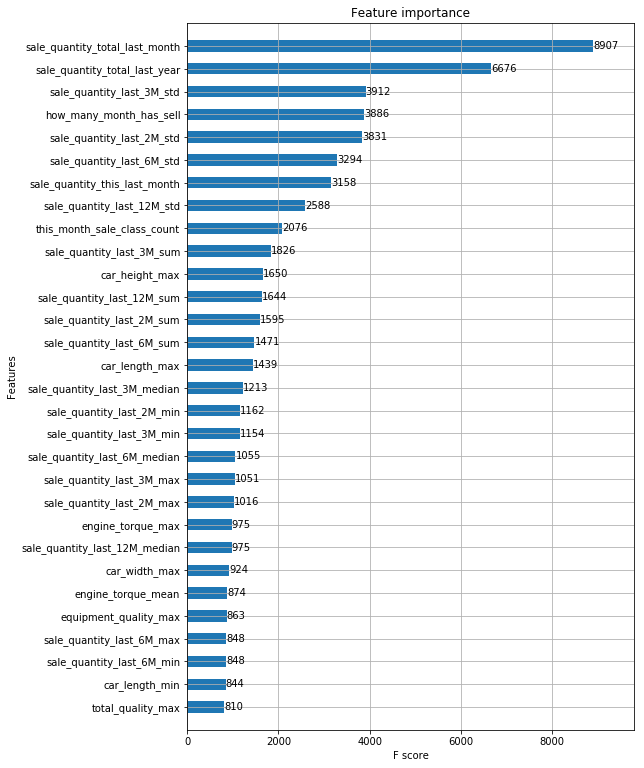

In [54]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=30, height=0.5, ax=ax)

## 利用全部训练集, 输出测试

In [175]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures2.csv')
# test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [176]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [177]:
class_id =np.array(train['class_id'])

In [178]:
# year 和 month 进行 one-hot 编码
train.drop_duplicates(inplace=True)
labels = train.sale_quantity[:8120]
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

test = train[8120:].reset_index(drop=True)
train = train[:8120].reset_index(drop=True)

In [180]:
train1=train
labels1=labels
test1=test
train1['class_id']=class_id[:8120]

test1['class_id']=class_id[8120:]

In [181]:
labels1=pd.DataFrame(labels1)

In [183]:
labels1['class_id']=class_id[:8120]

In [168]:
rmses = []
trainset = xgb.DMatrix(train, label=labels)
testset = xgb.DMatrix(test)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)

[0]	train-rmse:440.026
[1]	train-rmse:345.523
[2]	train-rmse:283.758
[3]	train-rmse:239.887
[4]	train-rmse:210.094
[5]	train-rmse:191.503
[6]	train-rmse:176.791
[7]	train-rmse:167.972
[8]	train-rmse:160.883
[9]	train-rmse:154.605
[10]	train-rmse:148.089
[11]	train-rmse:144.684
[12]	train-rmse:141.478
[13]	train-rmse:138.475
[14]	train-rmse:137.094
[15]	train-rmse:132.414
[16]	train-rmse:129.734
[17]	train-rmse:127.937
[18]	train-rmse:126.087
[19]	train-rmse:124.179
[20]	train-rmse:122.414
[21]	train-rmse:120.533
[22]	train-rmse:118.262
[23]	train-rmse:116.592
[24]	train-rmse:115.229
[25]	train-rmse:113.632
[26]	train-rmse:112.428
[27]	train-rmse:111.198
[28]	train-rmse:110.382
[29]	train-rmse:108.681
[30]	train-rmse:107.074
[31]	train-rmse:105.406
[32]	train-rmse:103.126
[33]	train-rmse:102.249
[34]	train-rmse:100.849
[35]	train-rmse:99.1839
[36]	train-rmse:98.3009
[37]	train-rmse:96.9703
[38]	train-rmse:95.6555
[39]	train-rmse:95.1268
[40]	train-rmse:93.8842
[41]	train-rmse:92.8121
[4

[334]	train-rmse:24.2403
[335]	train-rmse:24.1313
[336]	train-rmse:24.0773
[337]	train-rmse:23.9508
[338]	train-rmse:23.8974
[339]	train-rmse:23.847
[340]	train-rmse:23.7951
[341]	train-rmse:23.7087
[342]	train-rmse:23.6382
[343]	train-rmse:23.5775
[344]	train-rmse:23.4715
[345]	train-rmse:23.4106
[346]	train-rmse:23.2945
[347]	train-rmse:23.2015
[348]	train-rmse:23.1355
[349]	train-rmse:23.0509
[350]	train-rmse:22.9484
[351]	train-rmse:22.8809
[352]	train-rmse:22.7634
[353]	train-rmse:22.6871
[354]	train-rmse:22.6435
[355]	train-rmse:22.5999
[356]	train-rmse:22.528
[357]	train-rmse:22.4386
[358]	train-rmse:22.3734
[359]	train-rmse:22.3246
[360]	train-rmse:22.202
[361]	train-rmse:22.1505
[362]	train-rmse:22.0739
[363]	train-rmse:22.0287
[364]	train-rmse:21.9581
[365]	train-rmse:21.8854
[366]	train-rmse:21.8411
[367]	train-rmse:21.7683
[368]	train-rmse:21.6972
[369]	train-rmse:21.6218
[370]	train-rmse:21.522
[371]	train-rmse:21.461
[372]	train-rmse:21.4042
[373]	train-rmse:21.3264
[374]

[664]	train-rmse:9.62676
[665]	train-rmse:9.60584
[666]	train-rmse:9.57812
[667]	train-rmse:9.571
[668]	train-rmse:9.54862
[669]	train-rmse:9.5187
[670]	train-rmse:9.49996
[671]	train-rmse:9.47735
[672]	train-rmse:9.457
[673]	train-rmse:9.44119
[674]	train-rmse:9.41431
[675]	train-rmse:9.37373
[676]	train-rmse:9.34625
[677]	train-rmse:9.33386
[678]	train-rmse:9.31113
[679]	train-rmse:9.28815
[680]	train-rmse:9.26148
[681]	train-rmse:9.23207
[682]	train-rmse:9.20731
[683]	train-rmse:9.18227
[684]	train-rmse:9.16928
[685]	train-rmse:9.15406
[686]	train-rmse:9.13104
[687]	train-rmse:9.10526
[688]	train-rmse:9.07458
[689]	train-rmse:9.04607
[690]	train-rmse:9.01781
[691]	train-rmse:8.99969
[692]	train-rmse:8.97858
[693]	train-rmse:8.95827
[694]	train-rmse:8.93838
[695]	train-rmse:8.90546
[696]	train-rmse:8.88823
[697]	train-rmse:8.86498
[698]	train-rmse:8.82614
[699]	train-rmse:8.79955
[700]	train-rmse:8.7672
[701]	train-rmse:8.75426
[702]	train-rmse:8.72884
[703]	train-rmse:8.70642
[704]	

[994]	train-rmse:4.52122
[995]	train-rmse:4.50945
[996]	train-rmse:4.50066
[997]	train-rmse:4.49287
[998]	train-rmse:4.48782
[999]	train-rmse:4.48156
[1000]	train-rmse:4.47626
[1001]	train-rmse:4.46927
[1002]	train-rmse:4.46286
[1003]	train-rmse:4.44599
[1004]	train-rmse:4.42816
[1005]	train-rmse:4.42204
[1006]	train-rmse:4.41467
[1007]	train-rmse:4.39921
[1008]	train-rmse:4.37934
[1009]	train-rmse:4.36696
[1010]	train-rmse:4.362
[1011]	train-rmse:4.3509
[1012]	train-rmse:4.34411
[1013]	train-rmse:4.33504
[1014]	train-rmse:4.32981
[1015]	train-rmse:4.32025
[1016]	train-rmse:4.3124
[1017]	train-rmse:4.30353
[1018]	train-rmse:4.29545
[1019]	train-rmse:4.2844
[1020]	train-rmse:4.2727
[1021]	train-rmse:4.26549
[1022]	train-rmse:4.25718
[1023]	train-rmse:4.24794
[1024]	train-rmse:4.23865
[1025]	train-rmse:4.22857
[1026]	train-rmse:4.21868
[1027]	train-rmse:4.21096
[1028]	train-rmse:4.204
[1029]	train-rmse:4.1939
[1030]	train-rmse:4.18815
[1031]	train-rmse:4.17694
[1032]	train-rmse:4.16551
[

[1311]	train-rmse:2.45651
[1312]	train-rmse:2.45181
[1313]	train-rmse:2.44821
[1314]	train-rmse:2.44512
[1315]	train-rmse:2.44196
[1316]	train-rmse:2.43613
[1317]	train-rmse:2.4318
[1318]	train-rmse:2.42811
[1319]	train-rmse:2.42521
[1320]	train-rmse:2.4214
[1321]	train-rmse:2.41852
[1322]	train-rmse:2.41473
[1323]	train-rmse:2.40894
[1324]	train-rmse:2.40515
[1325]	train-rmse:2.40138
[1326]	train-rmse:2.39896
[1327]	train-rmse:2.39559
[1328]	train-rmse:2.39
[1329]	train-rmse:2.38737
[1330]	train-rmse:2.38408
[1331]	train-rmse:2.3822
[1332]	train-rmse:2.37883
[1333]	train-rmse:2.37649
[1334]	train-rmse:2.37506
[1335]	train-rmse:2.37311
[1336]	train-rmse:2.36869
[1337]	train-rmse:2.36348
[1338]	train-rmse:2.36178
[1339]	train-rmse:2.35705
[1340]	train-rmse:2.35214
[1341]	train-rmse:2.34873
[1342]	train-rmse:2.34097
[1343]	train-rmse:2.33794
[1344]	train-rmse:2.33478
[1345]	train-rmse:2.3291
[1346]	train-rmse:2.32611
[1347]	train-rmse:2.32363
[1348]	train-rmse:2.31996
[1349]	train-rmse:2

[1628]	train-rmse:1.51821
[1629]	train-rmse:1.51711
[1630]	train-rmse:1.51478
[1631]	train-rmse:1.51306
[1632]	train-rmse:1.51075
[1633]	train-rmse:1.50847
[1634]	train-rmse:1.50709
[1635]	train-rmse:1.50424
[1636]	train-rmse:1.50263
[1637]	train-rmse:1.50026
[1638]	train-rmse:1.49829
[1639]	train-rmse:1.49602
[1640]	train-rmse:1.49428
[1641]	train-rmse:1.49259
[1642]	train-rmse:1.4904
[1643]	train-rmse:1.48773
[1644]	train-rmse:1.48561
[1645]	train-rmse:1.48272
[1646]	train-rmse:1.48037
[1647]	train-rmse:1.47874
[1648]	train-rmse:1.47728
[1649]	train-rmse:1.47445
[1650]	train-rmse:1.47284
[1651]	train-rmse:1.47087
[1652]	train-rmse:1.46969
[1653]	train-rmse:1.46709
[1654]	train-rmse:1.46546
[1655]	train-rmse:1.46442
[1656]	train-rmse:1.46335
[1657]	train-rmse:1.46134
[1658]	train-rmse:1.46004
[1659]	train-rmse:1.45827
[1660]	train-rmse:1.45615
[1661]	train-rmse:1.45391
[1662]	train-rmse:1.45184
[1663]	train-rmse:1.44986
[1664]	train-rmse:1.44826
[1665]	train-rmse:1.44561
[1666]	train-

[1945]	train-rmse:1.00032
[1946]	train-rmse:0.999779
[1947]	train-rmse:0.998529
[1948]	train-rmse:0.997136
[1949]	train-rmse:0.996051
[1950]	train-rmse:0.995212
[1951]	train-rmse:0.994601
[1952]	train-rmse:0.993672
[1953]	train-rmse:0.99249
[1954]	train-rmse:0.991255
[1955]	train-rmse:0.98961
[1956]	train-rmse:0.988796
[1957]	train-rmse:0.988178
[1958]	train-rmse:0.987205
[1959]	train-rmse:0.986005
[1960]	train-rmse:0.984604
[1961]	train-rmse:0.984029
[1962]	train-rmse:0.982942
[1963]	train-rmse:0.981411
[1964]	train-rmse:0.980407
[1965]	train-rmse:0.979431
[1966]	train-rmse:0.978148
[1967]	train-rmse:0.977204
[1968]	train-rmse:0.976355
[1969]	train-rmse:0.975186
[1970]	train-rmse:0.974231
[1971]	train-rmse:0.972608
[1972]	train-rmse:0.97149
[1973]	train-rmse:0.970734
[1974]	train-rmse:0.969973
[1975]	train-rmse:0.968902
[1976]	train-rmse:0.967564
[1977]	train-rmse:0.966084
[1978]	train-rmse:0.96449
[1979]	train-rmse:0.96346
[1980]	train-rmse:0.962033
[1981]	train-rmse:0.961191
[1982]	

[2250]	train-rmse:0.721498
[2251]	train-rmse:0.720936
[2252]	train-rmse:0.71988
[2253]	train-rmse:0.718098
[2254]	train-rmse:0.717392
[2255]	train-rmse:0.716406
[2256]	train-rmse:0.715851
[2257]	train-rmse:0.715275
[2258]	train-rmse:0.714823
[2259]	train-rmse:0.714441
[2260]	train-rmse:0.713672
[2261]	train-rmse:0.713353
[2262]	train-rmse:0.712567
[2263]	train-rmse:0.711733
[2264]	train-rmse:0.711141
[2265]	train-rmse:0.710705
[2266]	train-rmse:0.710025
[2267]	train-rmse:0.709395
[2268]	train-rmse:0.708515
[2269]	train-rmse:0.707842
[2270]	train-rmse:0.706503
[2271]	train-rmse:0.705965
[2272]	train-rmse:0.705198
[2273]	train-rmse:0.703269
[2274]	train-rmse:0.702487
[2275]	train-rmse:0.70197
[2276]	train-rmse:0.701614
[2277]	train-rmse:0.70072
[2278]	train-rmse:0.699612
[2279]	train-rmse:0.699009
[2280]	train-rmse:0.698223
[2281]	train-rmse:0.697513
[2282]	train-rmse:0.697269
[2283]	train-rmse:0.696633
[2284]	train-rmse:0.695846
[2285]	train-rmse:0.694683
[2286]	train-rmse:0.69403
[2287

[2555]	train-rmse:0.531154
[2556]	train-rmse:0.530814
[2557]	train-rmse:0.530262
[2558]	train-rmse:0.529425
[2559]	train-rmse:0.528948
[2560]	train-rmse:0.528438
[2561]	train-rmse:0.528144
[2562]	train-rmse:0.527724
[2563]	train-rmse:0.527091
[2564]	train-rmse:0.52663
[2565]	train-rmse:0.526277
[2566]	train-rmse:0.526012
[2567]	train-rmse:0.525717
[2568]	train-rmse:0.525356
[2569]	train-rmse:0.524952
[2570]	train-rmse:0.524301
[2571]	train-rmse:0.523717
[2572]	train-rmse:0.523353
[2573]	train-rmse:0.522986
[2574]	train-rmse:0.522649
[2575]	train-rmse:0.522199
[2576]	train-rmse:0.52158
[2577]	train-rmse:0.521244
[2578]	train-rmse:0.521033
[2579]	train-rmse:0.520778
[2580]	train-rmse:0.520398
[2581]	train-rmse:0.519812
[2582]	train-rmse:0.519389
[2583]	train-rmse:0.519024
[2584]	train-rmse:0.518458
[2585]	train-rmse:0.518006
[2586]	train-rmse:0.517592
[2587]	train-rmse:0.517126
[2588]	train-rmse:0.516584
[2589]	train-rmse:0.516144
[2590]	train-rmse:0.515543
[2591]	train-rmse:0.515154
[25

[2860]	train-rmse:0.415434
[2861]	train-rmse:0.415263
[2862]	train-rmse:0.414907
[2863]	train-rmse:0.41456
[2864]	train-rmse:0.414254
[2865]	train-rmse:0.413989
[2866]	train-rmse:0.413671
[2867]	train-rmse:0.413349
[2868]	train-rmse:0.41299
[2869]	train-rmse:0.412636
[2870]	train-rmse:0.412265
[2871]	train-rmse:0.411953
[2872]	train-rmse:0.411791
[2873]	train-rmse:0.411423
[2874]	train-rmse:0.41101
[2875]	train-rmse:0.410823
[2876]	train-rmse:0.410424
[2877]	train-rmse:0.410095
[2878]	train-rmse:0.409802
[2879]	train-rmse:0.409433
[2880]	train-rmse:0.409153
[2881]	train-rmse:0.408638
[2882]	train-rmse:0.408153
[2883]	train-rmse:0.407794
[2884]	train-rmse:0.407468
[2885]	train-rmse:0.407312
[2886]	train-rmse:0.406934
[2887]	train-rmse:0.406677
[2888]	train-rmse:0.406058
[2889]	train-rmse:0.405681
[2890]	train-rmse:0.405484
[2891]	train-rmse:0.40525
[2892]	train-rmse:0.404974
[2893]	train-rmse:0.404491
[2894]	train-rmse:0.403967
[2895]	train-rmse:0.403854
[2896]	train-rmse:0.403628
[2897

[3165]	train-rmse:0.332277
[3166]	train-rmse:0.332107
[3167]	train-rmse:0.331756
[3168]	train-rmse:0.331536
[3169]	train-rmse:0.33135
[3170]	train-rmse:0.331211
[3171]	train-rmse:0.331035
[3172]	train-rmse:0.330865
[3173]	train-rmse:0.330757
[3174]	train-rmse:0.330522
[3175]	train-rmse:0.330309
[3176]	train-rmse:0.330074
[3177]	train-rmse:0.329909
[3178]	train-rmse:0.329767
[3179]	train-rmse:0.329463
[3180]	train-rmse:0.329283
[3181]	train-rmse:0.32903
[3182]	train-rmse:0.328673
[3183]	train-rmse:0.328406
[3184]	train-rmse:0.328261
[3185]	train-rmse:0.327961
[3186]	train-rmse:0.32773
[3187]	train-rmse:0.327282
[3188]	train-rmse:0.327051
[3189]	train-rmse:0.326776
[3190]	train-rmse:0.326559
[3191]	train-rmse:0.326287
[3192]	train-rmse:0.32615
[3193]	train-rmse:0.326099
[3194]	train-rmse:0.325911
[3195]	train-rmse:0.32537
[3196]	train-rmse:0.325187
[3197]	train-rmse:0.325101
[3198]	train-rmse:0.3249
[3199]	train-rmse:0.324648
[3200]	train-rmse:0.3245
[3201]	train-rmse:0.324421
[3202]	tra

[3470]	train-rmse:0.274239
[3471]	train-rmse:0.27408
[3472]	train-rmse:0.273946
[3473]	train-rmse:0.273678
[3474]	train-rmse:0.273473
[3475]	train-rmse:0.273414
[3476]	train-rmse:0.273108
[3477]	train-rmse:0.273
[3478]	train-rmse:0.272529
[3479]	train-rmse:0.272401
[3480]	train-rmse:0.272253
[3481]	train-rmse:0.272187
[3482]	train-rmse:0.272033
[3483]	train-rmse:0.271844
[3484]	train-rmse:0.271677
[3485]	train-rmse:0.271534
[3486]	train-rmse:0.271266
[3487]	train-rmse:0.271146
[3488]	train-rmse:0.27103
[3489]	train-rmse:0.270932
[3490]	train-rmse:0.270743
[3491]	train-rmse:0.270664
[3492]	train-rmse:0.270549
[3493]	train-rmse:0.2704
[3494]	train-rmse:0.270229
[3495]	train-rmse:0.269968
[3496]	train-rmse:0.269778
[3497]	train-rmse:0.269587
[3498]	train-rmse:0.269459
[3499]	train-rmse:0.26935
[3500]	train-rmse:0.269185
[3501]	train-rmse:0.269132
[3502]	train-rmse:0.268868
[3503]	train-rmse:0.268796
[3504]	train-rmse:0.268657
[3505]	train-rmse:0.26839
[3506]	train-rmse:0.26825
[3507]	trai

[3776]	train-rmse:0.237794
[3777]	train-rmse:0.237734
[3778]	train-rmse:0.23766
[3779]	train-rmse:0.237634
[3780]	train-rmse:0.237402
[3781]	train-rmse:0.237338
[3782]	train-rmse:0.237227
[3783]	train-rmse:0.237088
[3784]	train-rmse:0.237048
[3785]	train-rmse:0.236988
[3786]	train-rmse:0.236861
[3787]	train-rmse:0.236836
[3788]	train-rmse:0.236744
[3789]	train-rmse:0.236715
[3790]	train-rmse:0.236532
[3791]	train-rmse:0.236523
[3792]	train-rmse:0.236366
[3793]	train-rmse:0.236235
[3794]	train-rmse:0.236177
[3795]	train-rmse:0.236092
[3796]	train-rmse:0.235992
[3797]	train-rmse:0.235909
[3798]	train-rmse:0.23587
[3799]	train-rmse:0.235739
[3800]	train-rmse:0.235666
[3801]	train-rmse:0.235615
[3802]	train-rmse:0.235566
[3803]	train-rmse:0.235453
[3804]	train-rmse:0.235166
[3805]	train-rmse:0.23512
[3806]	train-rmse:0.234917
[3807]	train-rmse:0.234683
[3808]	train-rmse:0.234571
[3809]	train-rmse:0.234459
[3810]	train-rmse:0.23437
[3811]	train-rmse:0.23423
[3812]	train-rmse:0.234145
[3813]

In [185]:
predict_test_X1=predict_test_X

In [186]:
predict_test_X1=pd.DataFrame({'sale_quantity':predict_test_X1})

In [188]:
predict_test_X1['class_id']=class_id[8120:]

In [191]:
test2=test1
for i in test_Y_99_id:
    test2=test2[test2.class_id!=i]
    
train2=train1
for i in test_Y_99_id:
    train2=train2[train2.class_id!=i]
    
labels2=labels1
for i in test_Y_99_id:
    labels2=labels2[labels2.class_id!=i]

In [197]:
test2_1=test2.drop(['class_id'],axis=1)
train2_1=train2.drop(['class_id'],axis=1)
labels2_1=labels2.drop(['class_id'],axis=1)

In [203]:
%%time

rmses_100 = []
trainset_100 = xgb.DMatrix(train2_1,label=labels2_1)
testset_100 = xgb.DMatrix(test2_1)

params_100 = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear' , # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 2, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 6, # 树的最大深度。缺省值为6
'lambda': 20, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist_100 = [(trainset_100,'train')]
model_100 = xgb.train(params_100, trainset_100, num_boost_round=4000,evals=watchlist_100)
predict_test_X_100 = model_100.predict(testset_100)


[0]	train-rmse:708.581
[1]	train-rmse:566.52
[2]	train-rmse:468.775
[3]	train-rmse:400.607
[4]	train-rmse:353.286
[5]	train-rmse:321.075
[6]	train-rmse:298.831
[7]	train-rmse:280.376
[8]	train-rmse:266.362
[9]	train-rmse:252.395
[10]	train-rmse:242.783
[11]	train-rmse:233.575
[12]	train-rmse:227.722
[13]	train-rmse:216.895
[14]	train-rmse:208.36
[15]	train-rmse:201.77
[16]	train-rmse:196.973
[17]	train-rmse:191.658
[18]	train-rmse:186.547
[19]	train-rmse:182.853
[20]	train-rmse:179.193
[21]	train-rmse:173.841
[22]	train-rmse:168.375
[23]	train-rmse:164.375
[24]	train-rmse:162.166
[25]	train-rmse:159.655
[26]	train-rmse:155.333
[27]	train-rmse:151.612
[28]	train-rmse:148.988
[29]	train-rmse:146.732
[30]	train-rmse:144.266
[31]	train-rmse:142.229
[32]	train-rmse:140.558
[33]	train-rmse:138.593
[34]	train-rmse:137.207
[35]	train-rmse:134.401
[36]	train-rmse:131.885
[37]	train-rmse:129.95
[38]	train-rmse:128.849
[39]	train-rmse:127.039
[40]	train-rmse:125.522
[41]	train-rmse:123.867
[42]	t

[334]	train-rmse:8.068
[335]	train-rmse:8.02871
[336]	train-rmse:7.97713
[337]	train-rmse:7.91575
[338]	train-rmse:7.854
[339]	train-rmse:7.78463
[340]	train-rmse:7.72625
[341]	train-rmse:7.65884
[342]	train-rmse:7.57944
[343]	train-rmse:7.5319
[344]	train-rmse:7.46829
[345]	train-rmse:7.41297
[346]	train-rmse:7.35682
[347]	train-rmse:7.30147
[348]	train-rmse:7.26596
[349]	train-rmse:7.20453
[350]	train-rmse:7.14153
[351]	train-rmse:7.05789
[352]	train-rmse:6.98909
[353]	train-rmse:6.94288
[354]	train-rmse:6.90635
[355]	train-rmse:6.86978
[356]	train-rmse:6.84438
[357]	train-rmse:6.78678
[358]	train-rmse:6.72488
[359]	train-rmse:6.68247
[360]	train-rmse:6.62254
[361]	train-rmse:6.55206
[362]	train-rmse:6.5114
[363]	train-rmse:6.46749
[364]	train-rmse:6.42762
[365]	train-rmse:6.387
[366]	train-rmse:6.33803
[367]	train-rmse:6.28908
[368]	train-rmse:6.25082
[369]	train-rmse:6.21003
[370]	train-rmse:6.14895
[371]	train-rmse:6.11529
[372]	train-rmse:6.09027
[373]	train-rmse:6.05609
[374]	tr

[664]	train-rmse:1.09289
[665]	train-rmse:1.08441
[666]	train-rmse:1.08187
[667]	train-rmse:1.07794
[668]	train-rmse:1.07321
[669]	train-rmse:1.06771
[670]	train-rmse:1.06114
[671]	train-rmse:1.05616
[672]	train-rmse:1.04907
[673]	train-rmse:1.04546
[674]	train-rmse:1.04041
[675]	train-rmse:1.0333
[676]	train-rmse:1.02817
[677]	train-rmse:1.02544
[678]	train-rmse:1.02073
[679]	train-rmse:1.01632
[680]	train-rmse:1.01052
[681]	train-rmse:1.00466
[682]	train-rmse:0.999606
[683]	train-rmse:0.993276
[684]	train-rmse:0.989141
[685]	train-rmse:0.984425
[686]	train-rmse:0.977912
[687]	train-rmse:0.975273
[688]	train-rmse:0.96992
[689]	train-rmse:0.965017
[690]	train-rmse:0.960448
[691]	train-rmse:0.95493
[692]	train-rmse:0.948326
[693]	train-rmse:0.944823
[694]	train-rmse:0.938653
[695]	train-rmse:0.933163
[696]	train-rmse:0.930486
[697]	train-rmse:0.92662
[698]	train-rmse:0.923155
[699]	train-rmse:0.919045
[700]	train-rmse:0.914999
[701]	train-rmse:0.909538
[702]	train-rmse:0.905662
[703]	tr

[981]	train-rmse:0.318655
[982]	train-rmse:0.318348
[983]	train-rmse:0.317317
[984]	train-rmse:0.3164
[985]	train-rmse:0.315631
[986]	train-rmse:0.315064
[987]	train-rmse:0.314435
[988]	train-rmse:0.31375
[989]	train-rmse:0.313012
[990]	train-rmse:0.312224
[991]	train-rmse:0.311218
[992]	train-rmse:0.310474
[993]	train-rmse:0.309925
[994]	train-rmse:0.308641
[995]	train-rmse:0.307798
[996]	train-rmse:0.306945
[997]	train-rmse:0.306309
[998]	train-rmse:0.30556
[999]	train-rmse:0.30517
[1000]	train-rmse:0.304136
[1001]	train-rmse:0.3032
[1002]	train-rmse:0.302327
[1003]	train-rmse:0.301185
[1004]	train-rmse:0.300462
[1005]	train-rmse:0.299788
[1006]	train-rmse:0.298864
[1007]	train-rmse:0.298119
[1008]	train-rmse:0.297308
[1009]	train-rmse:0.296831
[1010]	train-rmse:0.295985
[1011]	train-rmse:0.295491
[1012]	train-rmse:0.294706
[1013]	train-rmse:0.293968
[1014]	train-rmse:0.292997
[1015]	train-rmse:0.292438
[1016]	train-rmse:0.291648
[1017]	train-rmse:0.290823
[1018]	train-rmse:0.290149


[1287]	train-rmse:0.206447
[1288]	train-rmse:0.206215
[1289]	train-rmse:0.205979
[1290]	train-rmse:0.20561
[1291]	train-rmse:0.205539
[1292]	train-rmse:0.205539
[1293]	train-rmse:0.205217
[1294]	train-rmse:0.205192
[1295]	train-rmse:0.205073
[1296]	train-rmse:0.205054
[1297]	train-rmse:0.204963
[1298]	train-rmse:0.204896
[1299]	train-rmse:0.204693
[1300]	train-rmse:0.204694
[1301]	train-rmse:0.204533
[1302]	train-rmse:0.204414
[1303]	train-rmse:0.204189
[1304]	train-rmse:0.204029
[1305]	train-rmse:0.203842
[1306]	train-rmse:0.203797
[1307]	train-rmse:0.203694
[1308]	train-rmse:0.203693
[1309]	train-rmse:0.203634
[1310]	train-rmse:0.203389
[1311]	train-rmse:0.203361
[1312]	train-rmse:0.203362
[1313]	train-rmse:0.203363
[1314]	train-rmse:0.203341
[1315]	train-rmse:0.203343
[1316]	train-rmse:0.203346
[1317]	train-rmse:0.202949
[1318]	train-rmse:0.202948
[1319]	train-rmse:0.202864
[1320]	train-rmse:0.20284
[1321]	train-rmse:0.202674
[1322]	train-rmse:0.202567
[1323]	train-rmse:0.202566
[13

[1592]	train-rmse:0.18578
[1593]	train-rmse:0.18578
[1594]	train-rmse:0.185582
[1595]	train-rmse:0.185401
[1596]	train-rmse:0.185347
[1597]	train-rmse:0.185278
[1598]	train-rmse:0.185115
[1599]	train-rmse:0.184938
[1600]	train-rmse:0.184938
[1601]	train-rmse:0.184923
[1602]	train-rmse:0.184871
[1603]	train-rmse:0.184873
[1604]	train-rmse:0.184825
[1605]	train-rmse:0.184766
[1606]	train-rmse:0.184661
[1607]	train-rmse:0.184465
[1608]	train-rmse:0.184451
[1609]	train-rmse:0.184464
[1610]	train-rmse:0.184318
[1611]	train-rmse:0.184317
[1612]	train-rmse:0.184228
[1613]	train-rmse:0.184228
[1614]	train-rmse:0.184228
[1615]	train-rmse:0.184209
[1616]	train-rmse:0.18421
[1617]	train-rmse:0.18421
[1618]	train-rmse:0.184008
[1619]	train-rmse:0.183946
[1620]	train-rmse:0.183953
[1621]	train-rmse:0.183957
[1622]	train-rmse:0.183899
[1623]	train-rmse:0.183899
[1624]	train-rmse:0.183889
[1625]	train-rmse:0.183842
[1626]	train-rmse:0.183792
[1627]	train-rmse:0.183767
[1628]	train-rmse:0.183683
[1629

[1897]	train-rmse:0.17625
[1898]	train-rmse:0.17614
[1899]	train-rmse:0.176139
[1900]	train-rmse:0.17614
[1901]	train-rmse:0.176141
[1902]	train-rmse:0.175983
[1903]	train-rmse:0.175982
[1904]	train-rmse:0.175859
[1905]	train-rmse:0.17586
[1906]	train-rmse:0.175862
[1907]	train-rmse:0.175869
[1908]	train-rmse:0.175869
[1909]	train-rmse:0.175868
[1910]	train-rmse:0.175868
[1911]	train-rmse:0.175869
[1912]	train-rmse:0.175868
[1913]	train-rmse:0.175868
[1914]	train-rmse:0.175868
[1915]	train-rmse:0.175868
[1916]	train-rmse:0.175868
[1917]	train-rmse:0.175868
[1918]	train-rmse:0.175776
[1919]	train-rmse:0.175776
[1920]	train-rmse:0.175775
[1921]	train-rmse:0.175777
[1922]	train-rmse:0.175775
[1923]	train-rmse:0.175775
[1924]	train-rmse:0.175752
[1925]	train-rmse:0.175752
[1926]	train-rmse:0.175617
[1927]	train-rmse:0.175617
[1928]	train-rmse:0.175616
[1929]	train-rmse:0.175489
[1930]	train-rmse:0.175453
[1931]	train-rmse:0.175468
[1932]	train-rmse:0.175246
[1933]	train-rmse:0.175245
[1934

[2202]	train-rmse:0.170281
[2203]	train-rmse:0.170282
[2204]	train-rmse:0.170179
[2205]	train-rmse:0.170179
[2206]	train-rmse:0.170118
[2207]	train-rmse:0.17012
[2208]	train-rmse:0.17012
[2209]	train-rmse:0.170068
[2210]	train-rmse:0.170067
[2211]	train-rmse:0.170068
[2212]	train-rmse:0.170067
[2213]	train-rmse:0.170068
[2214]	train-rmse:0.170069
[2215]	train-rmse:0.170068
[2216]	train-rmse:0.16992
[2217]	train-rmse:0.169815
[2218]	train-rmse:0.169813
[2219]	train-rmse:0.169815
[2220]	train-rmse:0.169813
[2221]	train-rmse:0.169814
[2222]	train-rmse:0.169814
[2223]	train-rmse:0.169669
[2224]	train-rmse:0.169669
[2225]	train-rmse:0.169669
[2226]	train-rmse:0.169633
[2227]	train-rmse:0.169636
[2228]	train-rmse:0.169527
[2229]	train-rmse:0.169467
[2230]	train-rmse:0.169462
[2231]	train-rmse:0.169465
[2232]	train-rmse:0.169464
[2233]	train-rmse:0.169341
[2234]	train-rmse:0.169338
[2235]	train-rmse:0.169337
[2236]	train-rmse:0.169338
[2237]	train-rmse:0.169337
[2238]	train-rmse:0.169193
[223

[2508]	train-rmse:0.166288
[2509]	train-rmse:0.166281
[2510]	train-rmse:0.166287
[2511]	train-rmse:0.166287
[2512]	train-rmse:0.166284
[2513]	train-rmse:0.166285
[2514]	train-rmse:0.166284
[2515]	train-rmse:0.166284
[2516]	train-rmse:0.166287
[2517]	train-rmse:0.166285
[2518]	train-rmse:0.166285
[2519]	train-rmse:0.166274
[2520]	train-rmse:0.166276
[2521]	train-rmse:0.166277
[2522]	train-rmse:0.16624
[2523]	train-rmse:0.166238
[2524]	train-rmse:0.166197
[2525]	train-rmse:0.166139
[2526]	train-rmse:0.16614
[2527]	train-rmse:0.166138
[2528]	train-rmse:0.166138
[2529]	train-rmse:0.166138
[2530]	train-rmse:0.166138
[2531]	train-rmse:0.166138
[2532]	train-rmse:0.16613
[2533]	train-rmse:0.16613
[2534]	train-rmse:0.166108
[2535]	train-rmse:0.16611
[2536]	train-rmse:0.166107
[2537]	train-rmse:0.166107
[2538]	train-rmse:0.165979
[2539]	train-rmse:0.16598
[2540]	train-rmse:0.16598
[2541]	train-rmse:0.16598
[2542]	train-rmse:0.16598
[2543]	train-rmse:0.165979
[2544]	train-rmse:0.165981
[2545]	tra

[2813]	train-rmse:0.163334
[2814]	train-rmse:0.163335
[2815]	train-rmse:0.163336
[2816]	train-rmse:0.163336
[2817]	train-rmse:0.163258
[2818]	train-rmse:0.163258
[2819]	train-rmse:0.163257
[2820]	train-rmse:0.163221
[2821]	train-rmse:0.163222
[2822]	train-rmse:0.163221
[2823]	train-rmse:0.163222
[2824]	train-rmse:0.163223
[2825]	train-rmse:0.163225
[2826]	train-rmse:0.163224
[2827]	train-rmse:0.163223
[2828]	train-rmse:0.163222
[2829]	train-rmse:0.163222
[2830]	train-rmse:0.163222
[2831]	train-rmse:0.163223
[2832]	train-rmse:0.163226
[2833]	train-rmse:0.163224
[2834]	train-rmse:0.163221
[2835]	train-rmse:0.163222
[2836]	train-rmse:0.163222
[2837]	train-rmse:0.163223
[2838]	train-rmse:0.163222
[2839]	train-rmse:0.163222
[2840]	train-rmse:0.163225
[2841]	train-rmse:0.163207
[2842]	train-rmse:0.163159
[2843]	train-rmse:0.163156
[2844]	train-rmse:0.163155
[2845]	train-rmse:0.163157
[2846]	train-rmse:0.163107
[2847]	train-rmse:0.163106
[2848]	train-rmse:0.163106
[2849]	train-rmse:0.163107
[

[3118]	train-rmse:0.161142
[3119]	train-rmse:0.161142
[3120]	train-rmse:0.161142
[3121]	train-rmse:0.161141
[3122]	train-rmse:0.16112
[3123]	train-rmse:0.161066
[3124]	train-rmse:0.161067
[3125]	train-rmse:0.161069
[3126]	train-rmse:0.161067
[3127]	train-rmse:0.161067
[3128]	train-rmse:0.161063
[3129]	train-rmse:0.161062
[3130]	train-rmse:0.161062
[3131]	train-rmse:0.161063
[3132]	train-rmse:0.161062
[3133]	train-rmse:0.161062
[3134]	train-rmse:0.161065
[3135]	train-rmse:0.161073
[3136]	train-rmse:0.16107
[3137]	train-rmse:0.161066
[3138]	train-rmse:0.161062
[3139]	train-rmse:0.160994
[3140]	train-rmse:0.160992
[3141]	train-rmse:0.160992
[3142]	train-rmse:0.160993
[3143]	train-rmse:0.160946
[3144]	train-rmse:0.160946
[3145]	train-rmse:0.160947
[3146]	train-rmse:0.160948
[3147]	train-rmse:0.160947
[3148]	train-rmse:0.160948
[3149]	train-rmse:0.160935
[3150]	train-rmse:0.160933
[3151]	train-rmse:0.160935
[3152]	train-rmse:0.160938
[3153]	train-rmse:0.160936
[3154]	train-rmse:0.160937
[31

[3423]	train-rmse:0.159381
[3424]	train-rmse:0.159389
[3425]	train-rmse:0.15939
[3426]	train-rmse:0.15939
[3427]	train-rmse:0.159389
[3428]	train-rmse:0.15938
[3429]	train-rmse:0.159381
[3430]	train-rmse:0.15938
[3431]	train-rmse:0.159381
[3432]	train-rmse:0.159353
[3433]	train-rmse:0.159351
[3434]	train-rmse:0.159351
[3435]	train-rmse:0.159352
[3436]	train-rmse:0.159352
[3437]	train-rmse:0.159351
[3438]	train-rmse:0.159352
[3439]	train-rmse:0.159351
[3440]	train-rmse:0.159351
[3441]	train-rmse:0.159351
[3442]	train-rmse:0.159353
[3443]	train-rmse:0.15935
[3444]	train-rmse:0.159351
[3445]	train-rmse:0.15935
[3446]	train-rmse:0.159351
[3447]	train-rmse:0.159351
[3448]	train-rmse:0.159351
[3449]	train-rmse:0.159326
[3450]	train-rmse:0.159327
[3451]	train-rmse:0.159329
[3452]	train-rmse:0.159331
[3453]	train-rmse:0.159329
[3454]	train-rmse:0.159319
[3455]	train-rmse:0.159319
[3456]	train-rmse:0.159321
[3457]	train-rmse:0.159324
[3458]	train-rmse:0.159324
[3459]	train-rmse:0.159319
[3460]	

[3728]	train-rmse:0.157609
[3729]	train-rmse:0.157605
[3730]	train-rmse:0.157604
[3731]	train-rmse:0.157605
[3732]	train-rmse:0.157606
[3733]	train-rmse:0.157606
[3734]	train-rmse:0.157608
[3735]	train-rmse:0.157609
[3736]	train-rmse:0.157607
[3737]	train-rmse:0.157606
[3738]	train-rmse:0.157607
[3739]	train-rmse:0.157612
[3740]	train-rmse:0.15761
[3741]	train-rmse:0.157538
[3742]	train-rmse:0.157537
[3743]	train-rmse:0.157537
[3744]	train-rmse:0.157538
[3745]	train-rmse:0.157537
[3746]	train-rmse:0.157541
[3747]	train-rmse:0.15754
[3748]	train-rmse:0.157538
[3749]	train-rmse:0.157538
[3750]	train-rmse:0.157539
[3751]	train-rmse:0.157538
[3752]	train-rmse:0.157538
[3753]	train-rmse:0.157538
[3754]	train-rmse:0.157545
[3755]	train-rmse:0.157539
[3756]	train-rmse:0.157539
[3757]	train-rmse:0.157538
[3758]	train-rmse:0.157537
[3759]	train-rmse:0.157542
[3760]	train-rmse:0.157538
[3761]	train-rmse:0.157441
[3762]	train-rmse:0.157458
[3763]	train-rmse:0.157453
[3764]	train-rmse:0.157452
[37

In [205]:
predict_test_X_100_1=predict_test_X_100

In [206]:
predict_test_X_100_1=pd.DataFrame({'sale_quantity':predict_test_X_100_1})

In [211]:
predict_test_X_100_1['class_id']=np.array(test2['class_id'])

In [224]:
for i in np.array(test2['class_id']):
    predict_test_X1.loc[predict_test_X1['class_id']==i,'sale_quantity']=float(predict_test_X_100_1.loc[predict_test_X_100_1['class_id']==i,'sale_quantity'])

In [228]:
predict_test_X2=np.array(predict_test_X1['sale_quantity'])

In [231]:
submit['predict_quantity'] = predict_test_X2
submit.to_csv('../../raw/Woody/result_20180209_xgboost-allfeatures.csv',index=False, header=True)  

## allfeatures + baseline *1.1

In [232]:
baseline = pd.read_csv('../../raw/Submissions/result_201710.csv')
submit['predict_quantity'] = baseline['predict_quantity'] * 1.1 * 0.5 + predict_test_X2 * 0.5

In [233]:
submit.to_csv('../../raw/Woody/result_20180209_xgboost-allfeatures*0.5-baseline*0.5*1.1.csv',index=False, header=True) 